In [224]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [225]:
image = cv2.imread(r"C:\Users\markd\Documents\GitHub\ArticusMaximus\python_edge_detection\sample_images\cursed_crop.jpg")
image = cv2.resize(image, (int(image.shape[1]/2), int(image.shape[0]/2)), interpolation=cv2.INTER_AREA)
cv2.imshow("image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [226]:
# Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imshow("gray", gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [227]:
# Threshold
ret, thresh = cv2.threshold(gray, 100, 225, cv2.THRESH_BINARY)
cv2.imshow("threshold", thresh)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [228]:
# Blur 
blur = cv2.GaussianBlur(gray, (5,5), sigmaX=0, sigmaY=0)
cv2.imshow("blur", blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [229]:
# Canny
canny = cv2.Canny(gray, 30, 200)
cv2.imshow("Canny", canny)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [230]:
# Canny w blur
canny_blur = cv2.Canny(blur, 30, 200)
cv2.imshow("Canny w blur", canny_blur)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [231]:
# Contour detection
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_NONE)

In [232]:
# Contour pre-processing
#[[Next, Previous, First_child, Parent]]
parents = []
children = []

for index, contour_hierarchy in enumerate(hierarchy[0]):
    if contour_hierarchy[3] == -1:
        parents.append(index)

parent_contours = []
for i in parents:
    parent_contours.append(contours[i])

len(contours), len(parent_contours)

(51, 36)

36


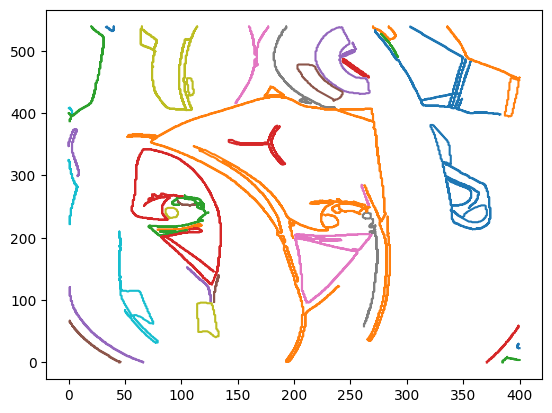

51


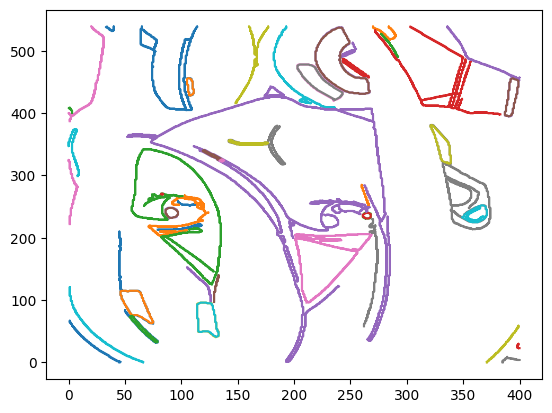

In [233]:
# All contours
# Contour detection
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_EXTERNAL  , cv2.CHAIN_APPROX_NONE)

num_contours = len(contours)
print(num_contours)
for i in range(num_contours):
    contour_img = contours[i]
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
plt.show()

contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_NONE)

num_contours = len(contours)
print(num_contours)
for i in range(num_contours):
    contour_img = contours[i]
    if contour_img.shape[0] != 1:
        contour_img = np.squeeze(contour_img)
        plt.plot(contour_img[:,0], contour_img[:,1], label=f'{i}')
plt.show()

In [234]:
contours, hierarchy = cv2.findContours(canny_blur, 
    cv2.RETR_TREE , cv2.CHAIN_APPROX_NONE)

cv2.drawContours(image, contours, -1, (0, 255, 0), 3)
cv2.imshow('Contours', image)
cv2.waitKey(0)
cv2.destroyAllWindows()